# Model selection using information criteria

author: Audrey Olivier

Theory background: model selection refers to the task of selecting a statistical model from a set of candidate models, given some data. A good model is amodel that is able to explain the data well (high model evidence). Given models of same explanatory power, the simplest model should be chosen (Ockam razor). Several simple criteria can be used to compute a model's quality and thus perform model selection. UQpy implements three citeria: 
<br>
Bayesian information criterion (BIC)
$$ BIC = ln(n) k - 2 ln(\hat{L}) $$

Akaike information criterion (AIC)
$$ AIC = 2 k - 2 ln (\hat{L})  $$

Corrected formula for AIC (AICc), for small data sets 
$$ AICc = AIC + \frac{2k(k+1)}{n-k-1} $$

For all formula above, $k$ is the number of parameters characterizing the model, $\hat{L}$ is the maximum value of the likelihood function and $n$ the number of data points. The best model is the one that minimizes the cirterion. All three formulas have a model fit term (find the model that minimizes the negative log likelihood) and a penalty term that increases as the number of model parameters (model complexity) increases.

Reference: *Burnham, K. P.; Anderson, D. R. (2002), Model Selection and Multimodel Inference: A Practical Information-Theoretic Approach (2nd ed.), Springer-Verlag, ISBN 0-387-95364-7*

## Example 1: selection between different distributions

In [1]:
# import the required packages
from UQpy.Inference import InfoModelSelection
from UQpy.Inference import Model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate data using one model a gamma distribution with shape 1, same as exponential
from scipy.stats import gamma
data = gamma(a = 2, loc = 0, scale = 1).rvs(size=200)
print(data.shape)

(200,)


In [3]:
# Define the models to be compared, for each model one must create an instance of the model class
model_names = ['exponential', 'gamma', 'chisquare']
candidate_models = []
for idx, model_name in enumerate(model_names):
    M = Model(model_name = model_name, model_type = 'pdf')
    candidate_models.append(M)

Sorted model using BIC criterion: chisquare, gamma, exponential
Sorted model using AIC criterion: chisquare, gamma, exponential
Sorted model using AICc criterion: chisquare, gamma, exponential


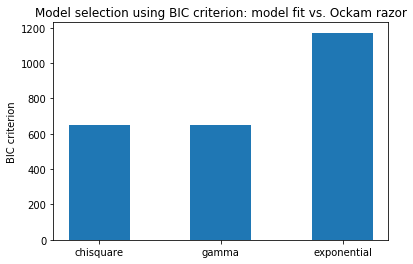

Shape parameter of the gamma distribution: 1.6753854798914063
DoF of the chisquare distribution: 3.350833232615436


In [4]:
# Perform model selection using different information criteria
criteria = ['BIC', 'AIC', 'AICc']
for criterion in criteria:
    selector = InfoModelSelection(candidate_models = candidate_models, data = data, method = criterion)
    print('Sorted model using '+criterion+' criterion: '+', '.join(x for x in selector.sorted_names))
    if criterion == 'BIC':
        criterion_value = selector.sorted_criteria
        sorted_names = selector.sorted_names
        param = selector.sorted_params
        
width = 0.5
ind = np.arange(len(sorted_names))
p1 = plt.bar(ind, criterion_value, width = width)
#p2 = plt.bar(ind, criterion_value-data_fit_value, bottom=data_fit_value, width = width)

plt.ylabel('BIC criterion')
plt.title('Model selection using BIC criterion: model fit vs. Ockam razor')
plt.xticks(ind, sorted_names)
#plt.legend((p1[0], p2[0]), ('Data fit', 'Ockam razor'))

plt.show()

print('Shape parameter of the gamma distribution: {}'.format(param[sorted_names.index('gamma')][0]))
print('DoF of the chisquare distribution: {}'.format(param[sorted_names.index('chisquare')][0]))

Note that here both the chisquare and gamma are capable of explaining the data, with $a = \nu/2$, $a$ is gamma's shape parameter and $\nu$ is the number of DOFs in chi-square distribution.

## Example 2: model selection in regression -  $y=F \theta + \epsilon$

In [5]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal
from UQpy.RunModel import RunModel

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)
print(param_true.shape)

z = RunModel(samples=param_true, model_type='python', model_script='pfn_quadratic.py')
data = z.model_eval.QOI[0]+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)

Evaluating the model...

[ -0.45472558   2.15975274   1.8861113    1.88787553   1.85416626
   0.81100243   4.67227095   5.87641842   8.22957238   9.93102624
  10.87568963  11.72122421  13.43523644  14.2199875   20.02636618
  20.36263435  24.51913806  27.11831293  31.64657832  35.850935
  37.65630915  39.74260929  44.98996093  48.43175558  51.4898417
  56.47389511  60.89218376  65.68966973  69.97453428  75.60529126
  82.44636088  84.67258247  90.43161328  97.7572298  104.08486389
 109.72033423 114.71340822 122.15318879 128.17790489 134.29395036
 139.63334556 148.51849926 155.31134325 161.93420834 169.49452956
 178.78155318 185.36746964 192.95322802 201.94034311 211.10294953]


In [6]:
# Create instances of the Model class for three models: linear, quadratic and cubic
names = ['linear', 'quadratic', 'cubic']
candidate_models = []
for i in range(3):
    M = Model(model_type='python', model_script='pfn_'+names[i]+'.py',model_name=names[i],
              error_covariance=error_covariance, n_params=i+1)
    candidate_models.append(M)

In [7]:
# Perform model selection using BIC criterion
selector = InfoModelSelection(candidate_models = candidate_models, data = data, method = 'BIC')
print('Sorted models: ', selector.sorted_names)
print('Value of criteria: ', selector.sorted_criteria)
print('Value of penalty term (complexity)', selector.sorted_penalty_terms)

Sorted models:  ['quadratic', 'cubic', 'linear']
Value of criteria:  [149.62060832096012, 152.83890502507836, 26192.140798376306]
Value of penalty term (complexity) [7.824046010856292, 11.736069016284437, 3.912023005428146]



Evaluating the model...


Evaluating the model...


Evaluating the model...



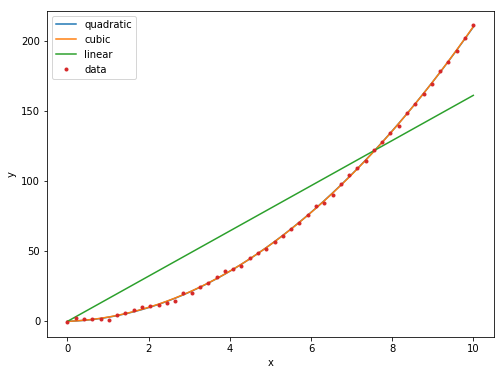

In [8]:
# Plot the results
domain = np.linspace(0, 10, 50)
fig, ax = plt.subplots(figsize=(8,6))

for i in range(3):
    z = RunModel(samples=selector.sorted_params[i].reshape((1,-1)), model_type='python', 
                 model_script='pfn_'+selector.sorted_names[i]+'.py')
    y = z.model_eval.QOI[0]
    ax.plot(domain, y, label = selector.sorted_names[i])

plt.plot(domain, data, linestyle='none', marker='.', label='data')
plt.xlabel('x')
plt.ylabel('y')
    
plt.legend()
plt.show()

For this case, one can observe that both the quadratic and cubic model are capable of explaining the data. The cubic model is penalized due to its higher complexity (penalty_term) and thus the quadratic model is preferred.